# Feature Engineer

In [62]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import MinMaxScaler


from collections import namedtuple, defaultdict

In [63]:
zip = zipfile.ZipFile('../data/archive.zip')
fp = zip.open('Historical Product Demand.csv') 
df = pd.read_csv(fp)


df.dropna(subset=['Date'], inplace=True)
df.dropna(subset=['Order_Demand'], inplace=True)

df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].astype('int64')

df['Date'] = pd.to_datetime(df['Date']) 
df.sort_values('Date', inplace=True)

df['Month']  = df['Date'].dt.month_name()
df['Year']   = df['Date'].dt.year
df['Months'] = df['Date'].dt.to_period('M').dt.to_timestamp()

/tmp/ipykernel_6152/1904672436.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
/tmp/ipykernel_6152/1904672436.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")


In [64]:
df_whse_a = df[df.Warehouse == 'Whse_A']

In [65]:
n_products = len(set(df_whse_a['Product_Code']))
n_rows = len(df_whse_a)
n_warehouse = len(set(df_whse_a['Warehouse']))
n_categories = len(set(df_whse_a['Product_Category']))

print(f"""
#rows:       {n_rows}
#products:   {n_products}
#categories: {n_categories}
#warehouse:  {n_warehouse}
""")


#rows:       142335
#products:   427
#categories: 25
#warehouse:  1



In [66]:
x = df_whse_a[(df_whse_a.Months >= '2012-01-01') & (df_whse_a.Months < '2017-01-01')].groupby('Months')['Order_Demand'].sum()
x = x.reset_index()

In [67]:
# choose a warehouse
df_whse_a.drop(['Warehouse', 'Product_Category'], axis=1, inplace=True)

/tmp/ipykernel_6152/3432016049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_whse_a.drop(['Warehouse', 'Product_Category'], axis=1, inplace=True)


In [68]:
# filter for freuent product
threshold = 1000
filtered_data = df_whse_a[(df_whse_a.Year >= 2012) & (df_whse_a.Year < 2017)]
frequent_products = filtered_data['Product_Code'].value_counts()[filtered_data['Product_Code'].value_counts() > threshold].index
filtered_data = filtered_data[filtered_data.Product_Code.isin(frequent_products)]

In [69]:
# aggregation
data_aggregated       = filtered_data[['Product_Code', 'Date', 'Order_Demand']]
data_aggregated       = data_aggregated.groupby(['Product_Code', 'Date']).sum().reset_index()

# weekly
data_pivot            = data_aggregated.pivot(index='Date', columns='Product_Code', values='Order_Demand').fillna(0)
data_resampled_weekly = data_pivot.resample('W').sum()

# daily
daily_index           = pd.date_range(start=data_resampled_weekly.index.min(), end=data_resampled_weekly.index.max(), freq='D')
data_resampled_daily  = data_resampled_weekly.reindex(daily_index).ffill() / 7

In [70]:
import numpy as np
from numpy.fft import fft

def spectrogram(audio, win = 7, step=1, normalize=True):
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        dft = np.abs(fft(audio[i - win: i] * hanning))
        if normalize:
            mu  = np.mean(dft)
            std = np.std(dft) + 1.0
            spectrogram.append((dft - mu) / std)
        else:
            spectrogram.append(dft)        
    spectrogram = np.array(spectrogram)[:, :win//2]
    return spectrogram


In [71]:
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

WEEK_IDX = {
  'Monday' : 0,
  'Tuesday': 1,
  'Wednesday': 2,
  'Thursday': 3,
  'Friday':4 ,
  'Saturday': 5,
  'Sunday': 6, 
}
def days_of_week(df, time_steps=1): 
    names = list(df.index.day_name())
    names = [WEEK_IDX[name] for name in names]
    X = []
    for i in range(len(names) - time_steps):
        X.append(names[i:(i + time_steps)])
    return np.array(X)


MONTH_IDX = {
    'January': 0,
    'February': 1,
    'March': 2,
    'April': 3,
    'May': 4,
    'June': 5,
    'July': 6,
    'August': 7,
    'September': 8,
    'October': 9,
    'November': 10,
    'December': 11
}
def month_of_year(df, time_steps=1): 
    names = list(df.index.month_name())
    names = [MONTH_IDX[name] for name in names]
    X = []
    for i in range(len(names) - time_steps):
        X.append(names[i:(i + time_steps)])
    return np.array(X)


def spectrogram_features(data, time_steps=1):
    t, d = data.shape
    spectrograms = []
    for i in range(0, d):
        spectrograms.append(spectrogram(data[:, i], win=30).T)
    stacked = np.stack(spectrograms).T
    X = []
    for i in range(len(stacked) - time_steps):
        X.append(stacked[i:(i + time_steps)])
    return np.array(X)

In [72]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_resampled_daily)

In [73]:
spec = spectrogram_features(scaled_data, time_steps=30)

In [74]:
month_features = month_of_year(data_resampled_daily, time_steps=30)

In [75]:
day_features = days_of_week(data_resampled_daily, time_steps=30)

In [76]:
time_steps = 30  # e.g., 30 days
X, y = create_sequences(scaled_data, time_steps)

In [77]:
X.shape, y.shape, month_features.shape, day_features.shape, spec.shape

((1791, 30, 31), (1791, 31), (1791, 30), (1791, 30), (1761, 30, 15, 31))

In [78]:
import pickle as pkl

Features = namedtuple('Features', 'seq month day spec lab')

with open('features.pkl', 'wb') as f:
    pkl.dump(Features(X, month_features, day_features, spec, y), f)

# Modeling

In [84]:
import pickle as pkl
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import * 
from tensorflow.keras.models import * 
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import * 
from tensorflow.keras.metrics import * 
Features = namedtuple('Features', 'seq month day spec lab')

In [85]:
features = pkl.load(open('features.pkl', 'rb'))
X_train, X_test, y_train, y_test = train_test_split(features.seq, features.lab, test_size=0.3)

In [86]:
print(X_train.shape, y_train.shape)

(1253, 30, 31) (1253, 31)


In [87]:
def predictor():
    i = Input((30, 31))
    x = LSTM(31, activation='relu')(i)
    return Model(inputs=[i], outputs=[x])

model = predictor()
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 30, 31)]          0         
                                                                 
 lstm_15 (LSTM)              (None, 31)                7812      
                                                                 
Total params: 7,812
Trainable params: 7,812
Non-trainable params: 0
_________________________________________________________________


In [88]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 5s 72ms/step - loss: 0.0461 - root_mean_squared_error: 0.2147 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2003
Epoch 2/50
40/40 [==============================] - 3s 66ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 3/50
40/40 [==============================] - 3s 69ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1937
Epoch 4/50
40/40 [==============================] - 2s 60ms/step - loss: 0.0375 - root_mean_squared_error: 0.1937 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1926
Epoch 5/50
40/40 [==============================] - 2s 62ms/step - loss: 0.0372 - root_mean_squared_error: 0.1929 - val_loss: 0.0369 - val_root_mean_squared_error: 0.1922
Epoch 6/50
40/40 [==============================] - 2s 62ms/step - loss: 0.0371 - root_mean_squared_error: 0.1925 - val_loss: 0.0368 - val_root_m

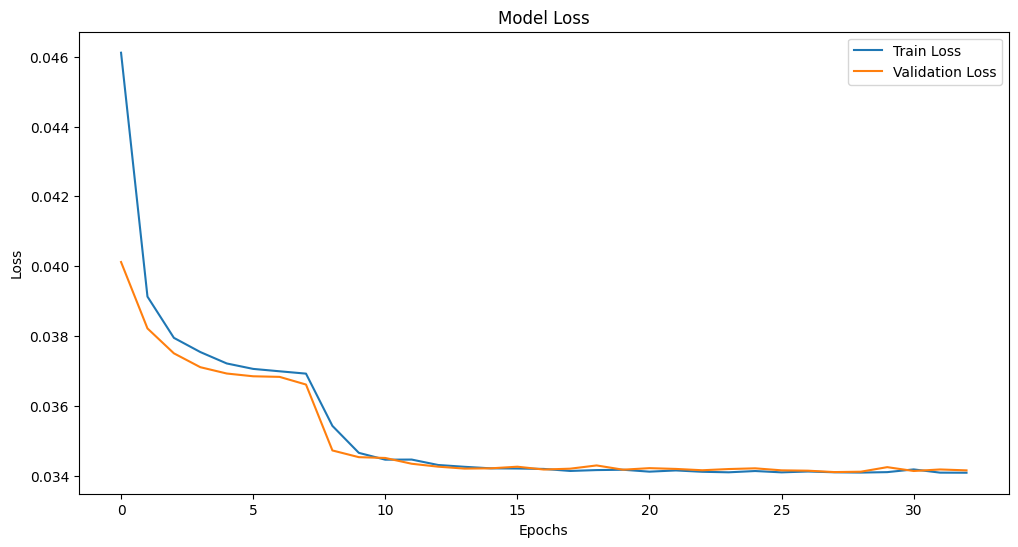

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [91]:
features.day.shape, features.month.shape

((1791, 30), (1791, 30))

In [176]:
def predictor_v2():
    i_seq = Input((30, 31))
    i_month = Input((30))
    i_day = Input((30))
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day])
    
    
    x = LSTM(31, activation='relu')(i)
    return Model(inputs=[i_seq, i_day, i_month], outputs=[x])

model = predictor_v2()
model.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_134 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 input_135 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 input_133 (InputLayer)         [(None, 30, 31)]     0           []                               
                                                                                                  
 embedding_52 (Embedding)       (None, 30, 12)       144         ['input_134[0][0]']              
                                                                                           

In [177]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test =\
train_test_split(features.seq, features.lab, features.day, features.month, test_size=0.3)

In [178]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test], y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 5s 77ms/step - loss: 0.1084 - root_mean_squared_error: 0.3292 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2198
Epoch 2/50
40/40 [==============================] - 3s 67ms/step - loss: 0.0491 - root_mean_squared_error: 0.2215 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2187
Epoch 3/50
40/40 [==============================] - 3s 67ms/step - loss: 0.0487 - root_mean_squared_error: 0.2208 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2183
Epoch 4/50
40/40 [==============================] - 3s 68ms/step - loss: 0.0486 - root_mean_squared_error: 0.2205 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2181
Epoch 5/50
40/40 [==============================] - 3s 67ms/step - loss: 0.0485 - root_mean_squared_error: 0.2203 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2180
Epoch 6/50
40/40 [==============================] - 3s 68ms/step - loss: 0.0485 - root_mean_squared_error: 0.2202 - val_loss: 0.0474 - val_root_m

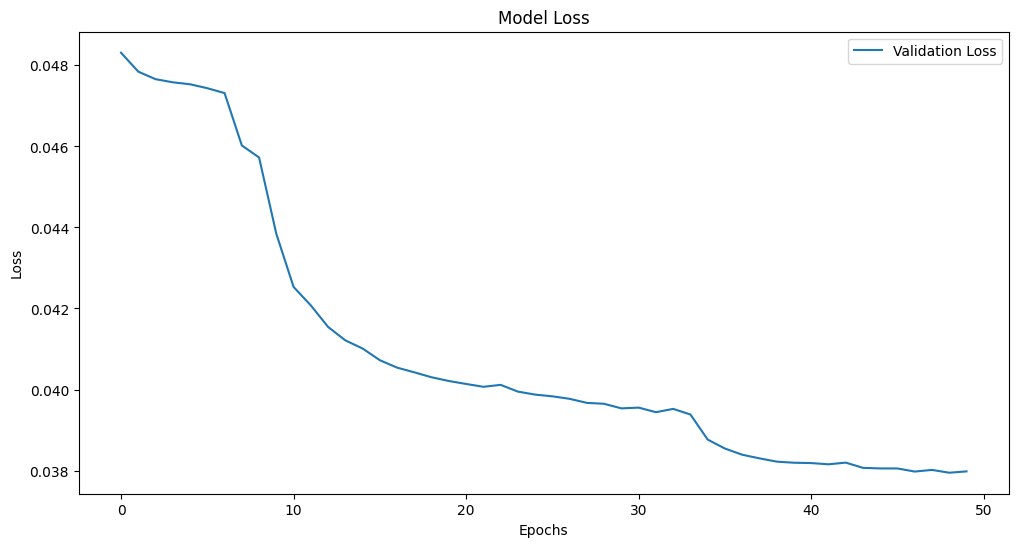

In [180]:
plt.figure(figsize=(12, 6))
# plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [169]:
def predictor_v2_2():
    i_seq = Input((30, 31))
    i_month = Input((30))
    i_day = Input((30))
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day])
    
    
    x = Bidirectional(LSTM(128, return_sequences=True))(i)
    x = LSTM(31, activation='relu')(x)
    return Model(inputs=[i_seq, i_day, i_month], outputs=[x])


model = predictor_v2_2()
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_128 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 input_129 (InputLayer)         [(None, 30)]         0           []                               
                                                                                                  
 input_127 (InputLayer)         [(None, 30, 31)]     0           []                               
                                                                                                  
 embedding_48 (Embedding)       (None, 30, 12)       144         ['input_128[0][0]']              
                                                                                           

In [170]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test =\
train_test_split(features.seq, features.lab, features.day, features.month, test_size=0.3)

In [171]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test], y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 [==============================] - 12s 116ms/step - loss: 641753.6875 - root_mean_squared_error: 801.0953 - val_loss: 0.1673 - val_root_mean_squared_error: 0.4090
Epoch 2/50
40/40 [==============================] - 3s 82ms/step - loss: 0.1208 - root_mean_squared_error: 0.3475 - val_loss: 0.0943 - val_root_mean_squared_error: 0.3071
Epoch 3/50
40/40 [==============================] - 3s 74ms/step - loss: 0.0886 - root_mean_squared_error: 0.2977 - val_loss: 0.0825 - val_root_mean_squared_error: 0.2873
Epoch 4/50
40/40 [==============================] - 3s 72ms/step - loss: 0.0972 - root_mean_squared_error: 0.3118 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2855
Epoch 5/50
40/40 [==============================] - 3s 79ms/step - loss: 0.0828 - root_mean_squared_error: 0.2877 - val_loss: 0.0802 - val_root_mean_squared_error: 0.2831
Epoch 6/50
40/40 [==============================] - 3s 77ms/step - loss: 0.0804 - root_mean_squared_error: 0.2836 - val_loss: 0.0782 - v

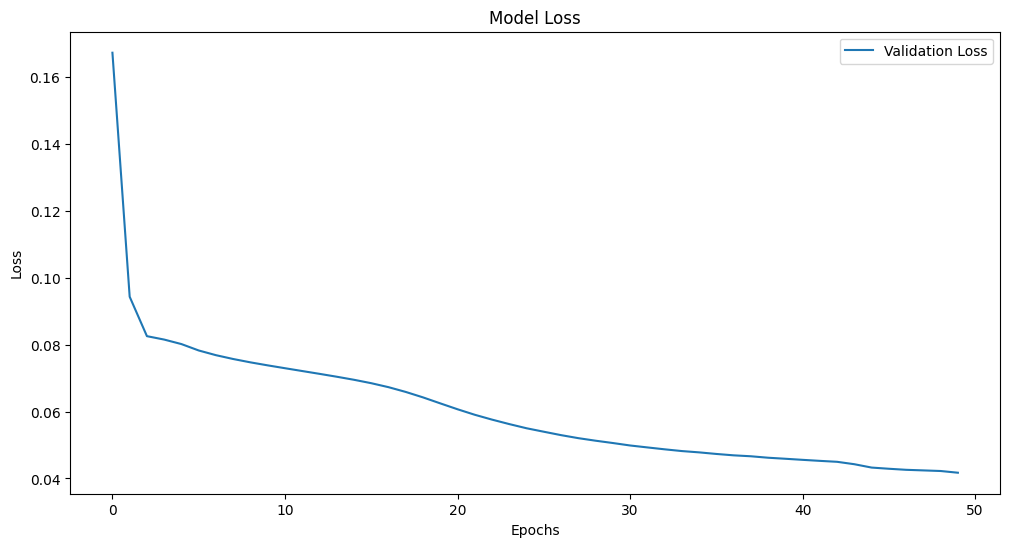

In [173]:
plt.figure(figsize=(12, 6))
#plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [111]:
features.spec.shape

(1761, 30, 15, 31)

In [161]:
def predictor_v3():
    i_seq = Input((30, 31))
    i_month = Input((30))
    i_day = Input((30))
    i_spec = Input((30, 15, 31))
    
    c_spec = BatchNormalization()(i_spec)
    c_spec = Convolution2D(128, kernel_size=(7, 15), padding='same')(c_spec)
    c_spec = MaxPool2D((1, 15))(c_spec)
    c_spec = Reshape((30, 128))(c_spec)
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day, c_spec])
    
    
    x = LSTM(31, activation='relu')(i)
    return Model(inputs=[i_seq, i_day, i_month, i_spec], outputs=[x])

model = predictor_v3()
model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_120 (InputLayer)         [(None, 30, 15, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 30, 15, 31)  124         ['input_120[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 conv2d_15 (Conv2D)             (None, 30, 15, 128)  416768      ['batch_normalization_3[0][0]']  
                                                                                           

In [162]:
n = features.spec.shape[0]

In [163]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test, spec_train, spec_test =\
train_test_split(features.seq[:n], features.lab[:n], features.day[:n], features.month[:n], features.spec, test_size=0.3)

In [164]:
X_train.shape, month_train.shape, day_train.shape, spec_train.shape

((1232, 30, 31), (1232, 30), (1232, 30), (1232, 30, 15, 31))

In [165]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train, spec_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test, spec_test], y_test), callbacks=[early_stopping])

Epoch 1/50
39/39 [==============================] - 6s 92ms/step - loss: 28554.9512 - root_mean_squared_error: 168.9821 - val_loss: 7043.9155 - val_root_mean_squared_error: 83.9280
Epoch 2/50
39/39 [==============================] - 3s 73ms/step - loss: 24067.0117 - root_mean_squared_error: 155.1355 - val_loss: 6402.9634 - val_root_mean_squared_error: 80.0185
Epoch 3/50
39/39 [==============================] - 3s 78ms/step - loss: 11597.4639 - root_mean_squared_error: 107.6915 - val_loss: 1953.9220 - val_root_mean_squared_error: 44.2032
Epoch 4/50
39/39 [==============================] - 3s 76ms/step - loss: 1248.8240 - root_mean_squared_error: 35.3387 - val_loss: 7.1831 - val_root_mean_squared_error: 2.6801
Epoch 5/50
39/39 [==============================] - 3s 75ms/step - loss: 3.9960 - root_mean_squared_error: 1.9990 - val_loss: 0.5690 - val_root_mean_squared_error: 0.7543
Epoch 6/50
39/39 [==============================] - 3s 75ms/step - loss: 1.5684 - root_mean_squared_error: 1.25

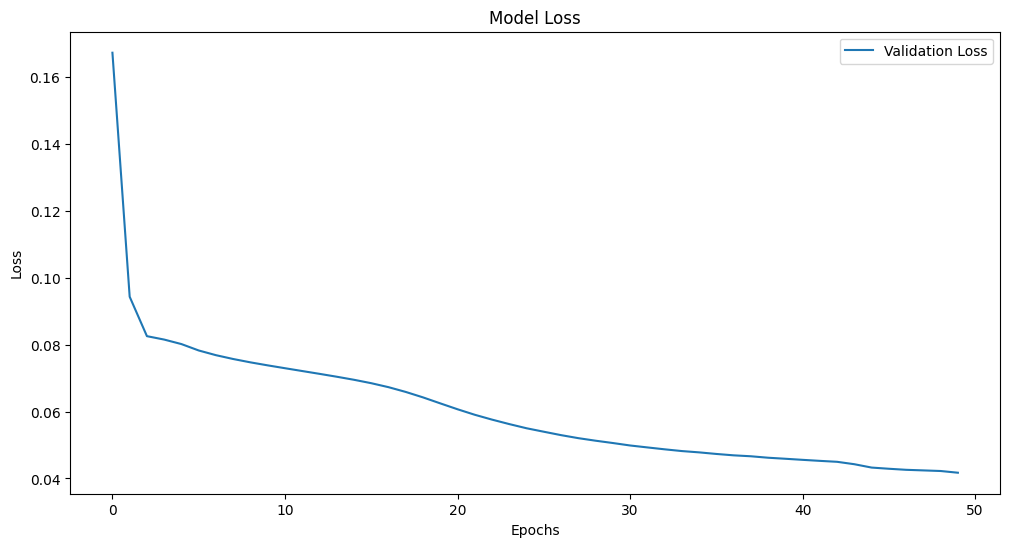

In [174]:
plt.figure(figsize=(12, 6))
#plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()